In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hnc_n_multiscale import  HNC_solver

# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}

Define physical constants

In [2]:
# k_B = 1.380649e-23  # Boltzmann constant [J/K]
# hbar=  6.62607015e-34 # Planck [J/s]
eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
Kelvin = 8.61732814974493e-5*eV #Similarly, 1 Kelvin = 3.167e-6... in natural units 
aB = 5.29177210903e-11 # Bohr radius in m

π = np.pi
# [AU]
ni = 5.01e23*1e6
# rs = (4/3*π*ni)**(-1/3)/aB
rs  = 3
T   = 1*eV 
Zstar=3#

ne = Zstar*(4/3*np.pi*rs**3)**(-1)
lambda_TF = np.sqrt( T / (4*np.pi*ne)  )

β   = 1/T
m_e = 1

Λe  = np.sqrt(  β*2*π /m_e )
Λe_star  = np.sqrt(  β*2*π /m_e )/rs
print("Λee = {0:.3f}".format(Λe_star))
Γee = β/rs 
Γei = -Zstar*β/rs 
Γii = Zstar**2*β/rs 
print("Γii={0:.1f}, Γie={1:.1f}, Γee={2:.1f} ".format(Γee, Γei, Γii))
print("r_s={0:.1f}".format(rs))

def βv_Yukawa(r):
    return Γii/r * np.exp(-r*rs/lambda_TF)

Λee = 4.358
Γii=9.1, Γie=-27.2, Γee=81.6 
r_s=3.0


##### Load MM Data

In [3]:
# from pandas import read_csv

# r_ie, gie = np.array(read_csv("~/plasma/MM_HNC/gie.out", delim_whitespace=True)).T
# r_ee, gee = np.array(read_csv("~/plasma/MM_HNC/gee.out", delim_whitespace=True)).T
# r_ii, gii = np.array(read_csv("~/plasma/MM_HNC/gii.out", delim_whitespace=True)).T

# data_to_compare = [gie,gee,gii]
# data_to_compare = ["~/plasma/MM_HNC/gie.out","~/plasma/MM_HNC/gee.out","~/plasma/MM_HNC/gii.out"]
# data_names=['MM ie', "MM ee", 'MM ii' ]

Plug into get potentials

In [4]:
from scipy.special import erfc

# Build Components for QSP's

def βv_Deutsch(Γ, r):
    return Γ/r*  np.exp(-2*π*r/Λe_star)

# Kelbg looks really weird??
def βv_Kelbg(Γ,r):
    return Γ/r*( 1 - np.exp(-2*π*r**2/Λe_star**2)+ np.sqrt(2)*π*r/Λe_star*erfc(np.sqrt(2*π)*r/Λe_star))

def βv_Pauli(r):
    return  np.log(2) * np.exp(-4*π* r**2 /( Λe_star**2))


######### Build Actual QSP's

def βvee(r):
    return βv_Kelbg(Γee,r) + βv_Pauli(r)

def βvei(r):
    return βv_Kelbg(Γei,r)

# def βvei_atomic(r):
#     r_c = 3/5 #3/5 r_s in linear n_b(r) model
#     return np.heaviside(r - r_c,0.5) * βvei(r)

def βvii(r):
    return Γii/r 



First, we initialize the hnc

In [5]:
N_species = 2
Gamma = np.array(  [[Γii,  Γei],
                    [Γei,  Γee]])


# Gamma = np.array(  [[50,  10],
#                     [10,  10]])

names = ["Ion-1", "Electron", ] 
kappa = 1
rho = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-6,
                 kappa_multiscale=1, rho = rho, num_iterations=int(1e3), 
                 R_max=10, N_bins=1000, names=names, dst_type=3)



In [6]:
βu_r_matrix = np.array([[βvii(hnc2.r_array), βvei(hnc2.r_array)],
                        [βvei(hnc2.r_array), βvee(hnc2.r_array)]])

hnc2.set_βu_matrix(βu_r_matrix)
hnc2.initialize_c_k()
hnc2.set_C_matrix()

/home/zach/plasma/hnc/hnc_n_multiscale.py:476: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0,10)


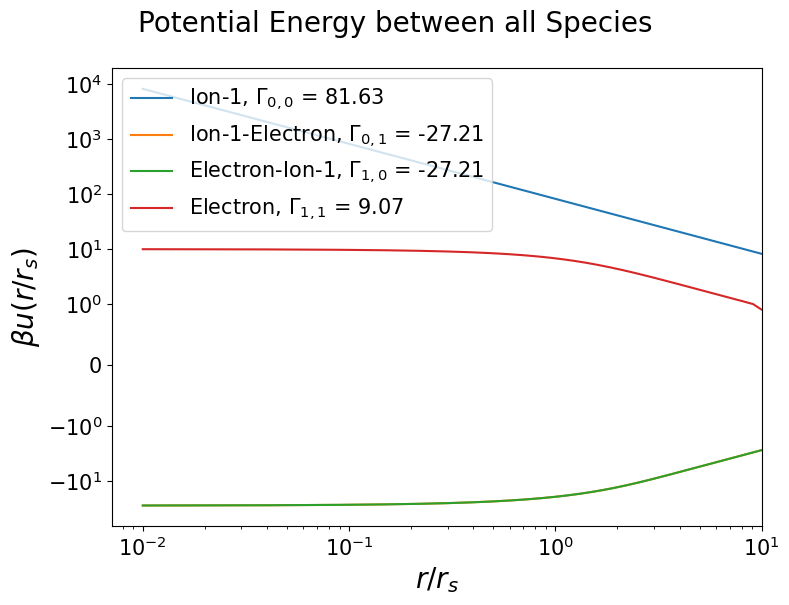

In [7]:
hnc2.plot_βu_all_species()

In [8]:
hnc2.HNC_solve(alpha=0.001, h_max=5e2)

0: Err in c_r: 178.048
1: Err in c_r: 28.127
2: Err in c_r: 10.641
3: Err in c_r: 5.995
4: Err in c_r: 4.069
5: Err in c_r: 3.093
6: Err in c_r: 2.426
7: Err in c_r: 1.994
8: Err in c_r: 1.647
9: Err in c_r: 1.404
10: Err in c_r: 1.202
11: Err in c_r: 1.046
12: Err in c_r: 0.917
13: Err in c_r: 0.810
14: Err in c_r: 0.721
15: Err in c_r: 0.645
16: Err in c_r: 0.579
17: Err in c_r: 0.523
18: Err in c_r: 0.474
19: Err in c_r: 0.430
20: Err in c_r: 0.392
21: Err in c_r: 0.358
22: Err in c_r: 0.328
23: Err in c_r: 0.300
24: Err in c_r: 0.276
25: Err in c_r: 0.254
26: Err in c_r: 0.234
27: Err in c_r: 0.216
28: Err in c_r: 0.199
29: Err in c_r: 0.184
30: Err in c_r: 0.170
31: Err in c_r: 0.158
32: Err in c_r: 0.146
33: Err in c_r: 0.135
34: Err in c_r: 0.126
35: Err in c_r: 0.117
36: Err in c_r: 0.108
37: Err in c_r: 0.101
38: Err in c_r: 0.094
39: Err in c_r: 0.087
40: Err in c_r: 0.081
41: Err in c_r: 0.076
42: Err in c_r: 0.070
43: Err in c_r: 0.066
44: Err in c_r: 0.061
45: Err in c_r: 

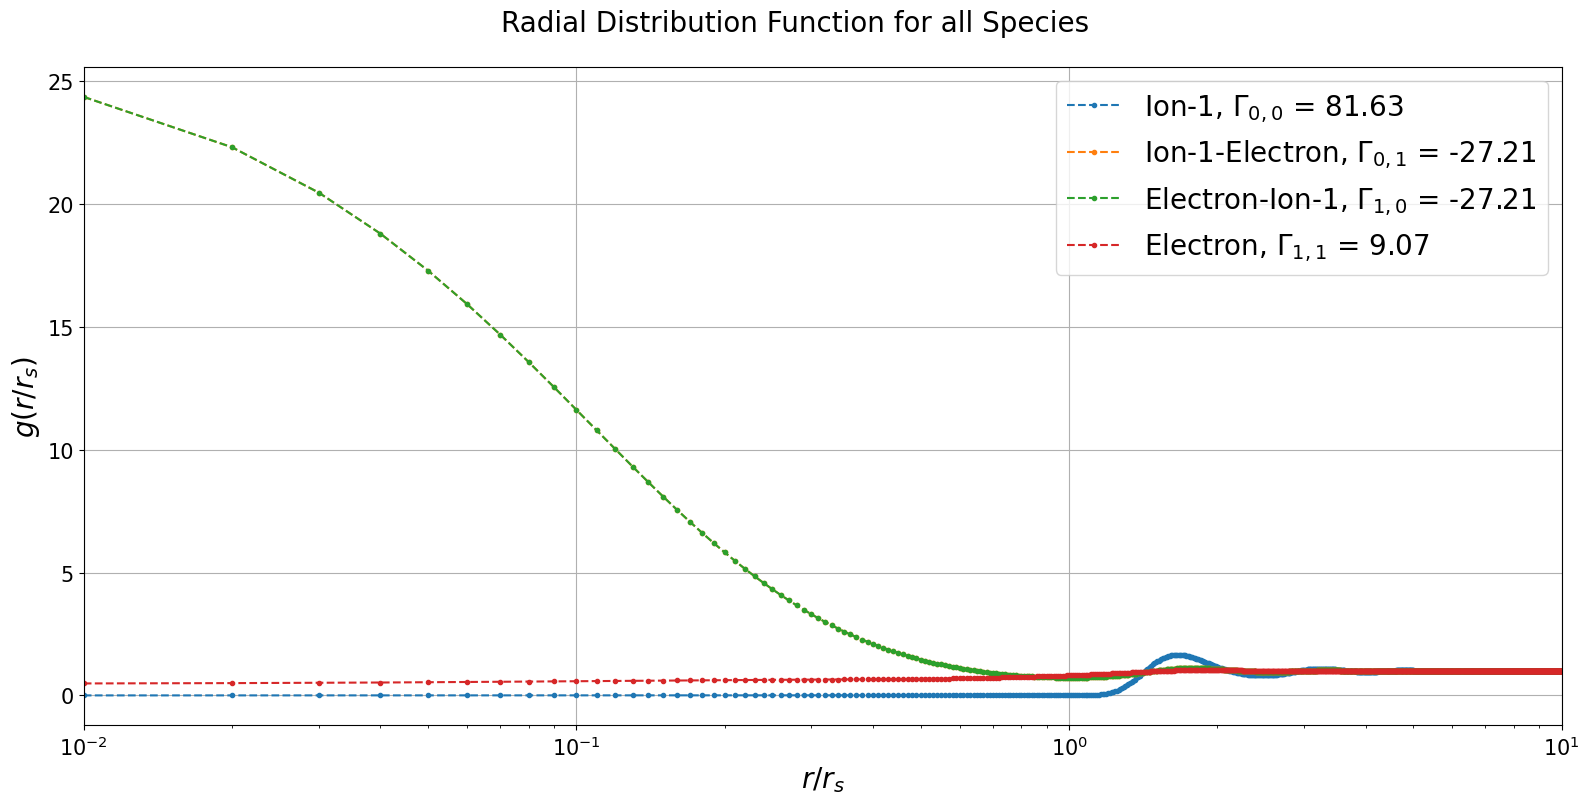

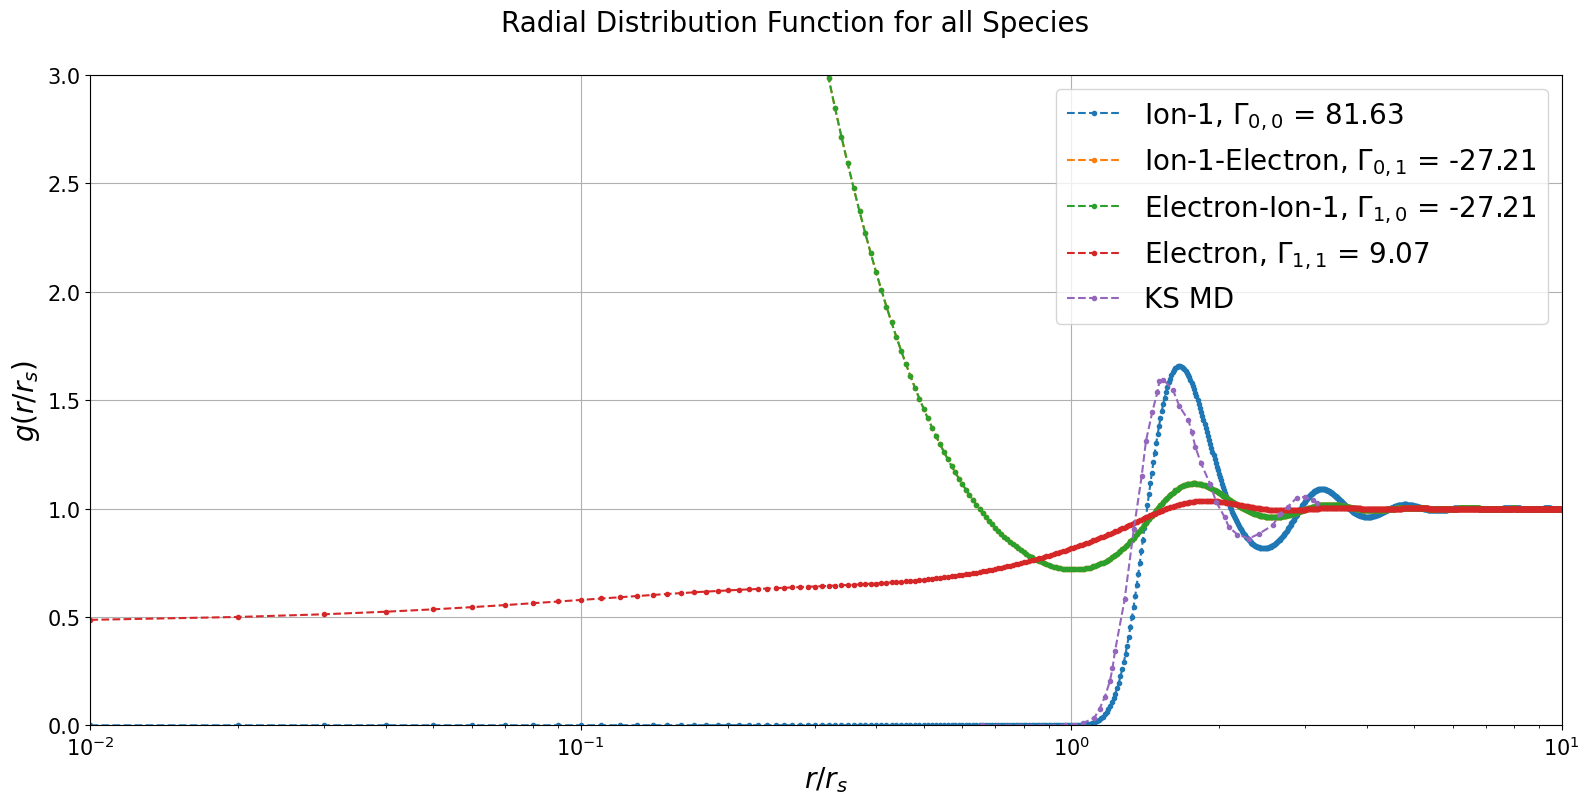

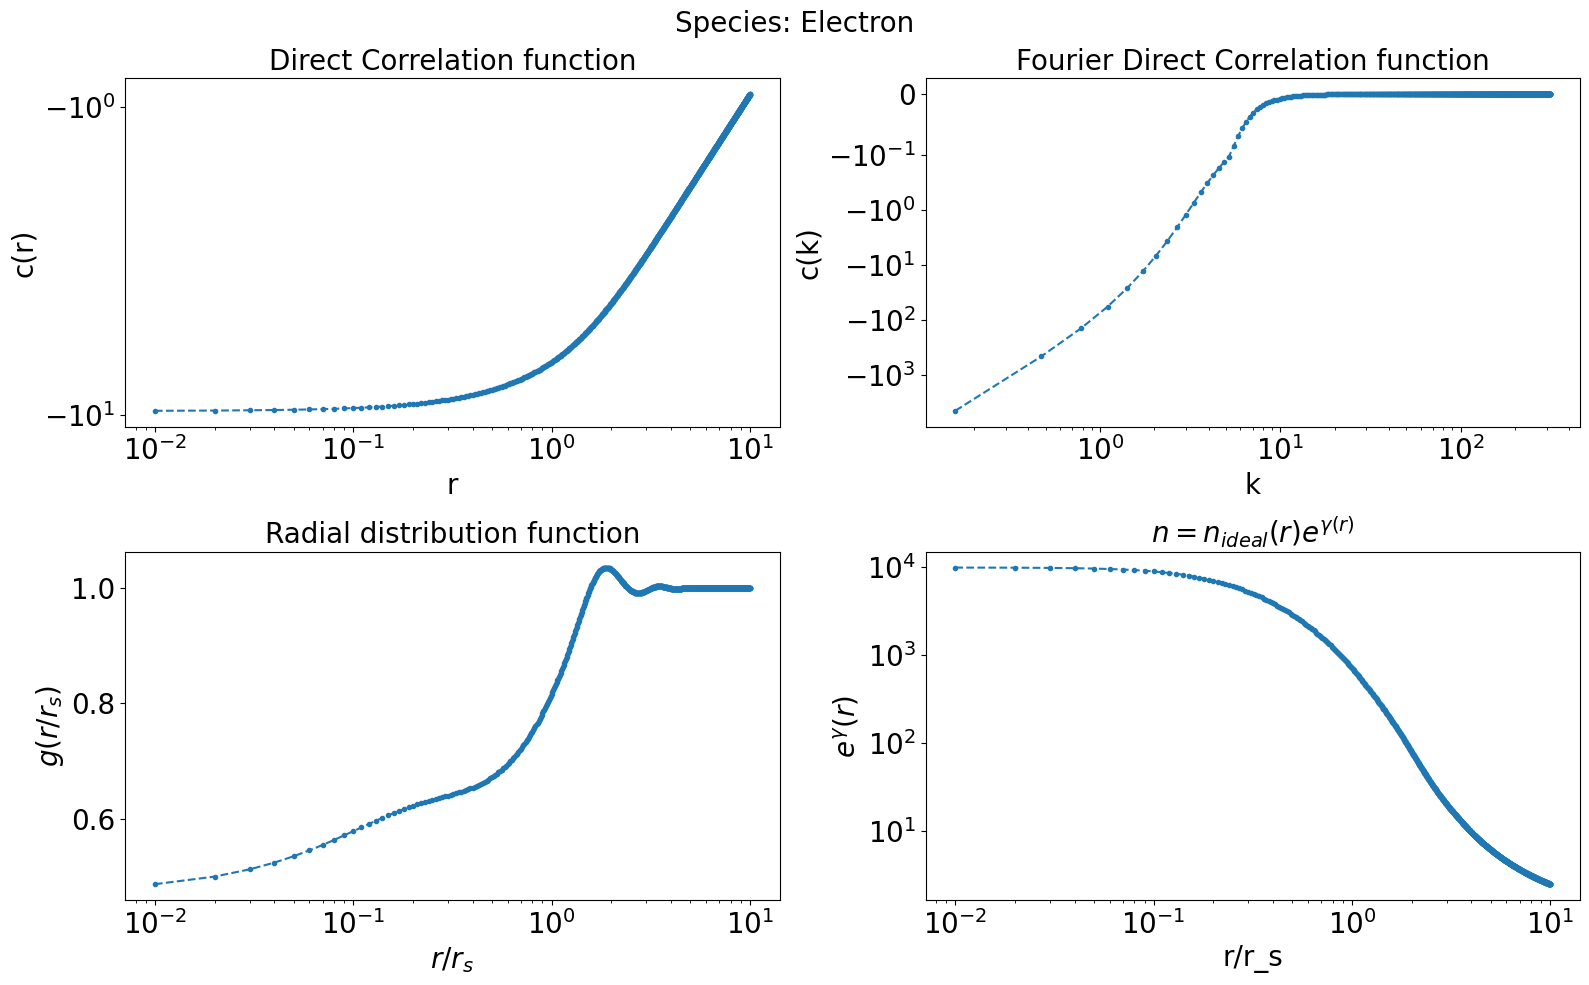

In [9]:
hnc2.plot_g_all_species()
hnc2.plot_g_all_species(data_to_compare=['/home/zach/plasma/atomic_forces/data/RDF/Al_1.0eV_rs3_KS-MD.txt'], data_names=['KS MD'], gmax=3)
hnc2.plot_species((1,1))

# Effective Potentials

In [10]:
hnc2.invert_HNC(1)

/tmp/ipykernel_27306/3332355128.py:5: RuntimeWarning: divide by zero encountered in log
  ax.plot(hnc2.r_array,np.log(1+hnc2.heff_r_matrix)[0,0],label='log(1+h)')


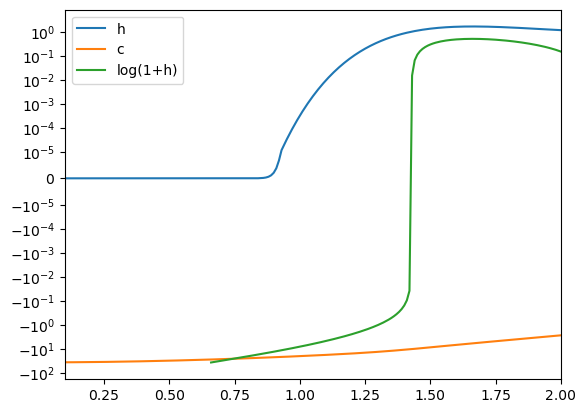

In [11]:
fig, ax = plt.subplots()

ax.plot(hnc2.r_array, 1+hnc2.heff_r_matrix[0,0],label= 'h')
ax.plot(hnc2.r_array, hnc2.ceff_r_matrix[0,0],label='c')
ax.plot(hnc2.r_array,np.log(1+hnc2.heff_r_matrix)[0,0],label='log(1+h)')
ax.set_yscale('symlog',linthresh=1e-5)
ax.set_xlim(1e-1,2)
# ax.set_xscale('log')
ax.legend()

In [12]:
hnc2.βωeff_r_matrix

array([[[ 8.05934631e+03,  3.97786664e+03,  2.61739951e+03,
          1.93719501e+03,  1.52910289e+03,  1.25707284e+03,
          1.06279736e+03,  9.17122504e+02,  8.03851466e+02,
          7.13265998e+02,  6.39181628e+02,  5.77475250e+02,
          5.25292303e+02,  4.80593721e+02,  4.41884107e+02,
          4.08041843e+02,  3.78209158e+02,  3.51718842e+02,
          3.28044102e+02,  3.06763460e+02,  2.87535684e+02,
          2.70081549e+02,  2.54170361e+02,  2.39609850e+02,
          2.26238484e+02,  2.13919562e+02,  2.02536615e+02,
          1.91989795e+02,  1.82193010e+02,  1.73071634e+02,
          1.64560656e+02,  1.56603178e+02,  1.49149190e+02,
          1.42154552e+02,  1.35580162e+02,  1.29391251e+02,
          1.23556802e+02,  1.18049053e+02,  1.12843084e+02,
          1.07916458e+02,  1.03248921e+02,  9.88221404e+01,
          9.46194839e+01,  9.06258244e+01,  8.68273738e+01,
          8.32115375e+01,  7.97667871e+01,  7.64825499e+01,
          7.33491110e+01,  7.03575280e+0

In [14]:
from pandas import read_csv
from scipy.interpolate import interp1d
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
luke_r,luke_βV = 1e-10/aB/rs*luke_data['r [A]'], 1/(T/eV)*luke_data['V [eV]']
luke_r[165], luke_βV[165]
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

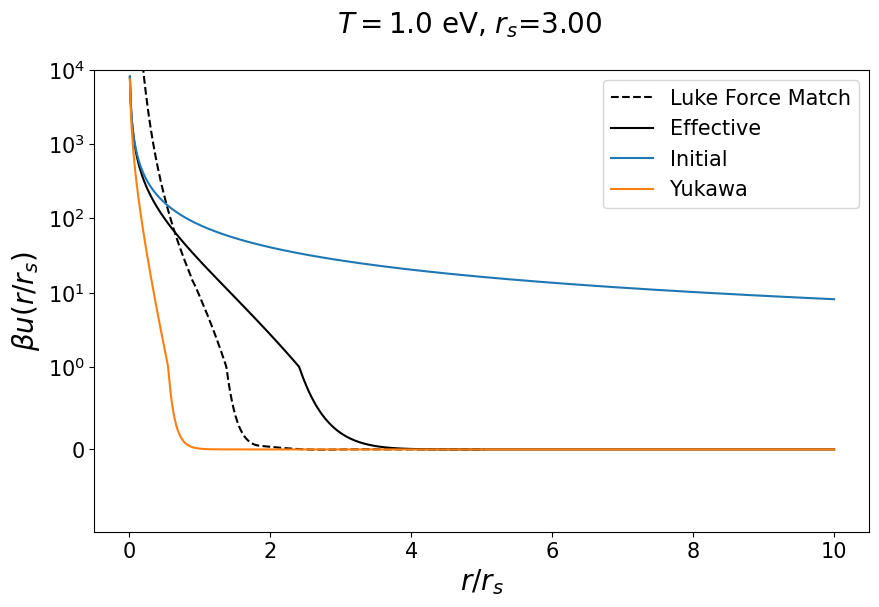

In [21]:
fig, ax = plt.subplots(figsize=(10,6),facecolor='w')
fig.suptitle(r"$T=${0:.1f} eV, $r_s$={1:.2f}".format(T/eV,rs), fontsize=20)

ax.plot(luke_r, luke_βV,'k--', label="Luke Force Match")
ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
ax.plot(hnc2.r_array, hnc2.βu_r_matrix[0,0], label="Initial")
ax.plot(hnc2.r_array, βv_Yukawa(hnc2.r_array),label="Yukawa")
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-1,1e4)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Check!

In [16]:
# N_species = 1
# Gamma = np.array(  [[1]])
# names = ["Ion Effective"] 
# kappa = 1
# rho = np.array([3/(4*np.pi)])
# hnc_check = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=10,
#                        rho = rho, num_iterations=int(1e3), R_max=10, N_bins=1000, names=names)

# hnc_luke = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=10,
#                        rho = rho, num_iterations=int(1e4), R_max=10, N_bins=1000, names=names)

# # check
# βu_r_matrix = np.nan_to_num( hnc2.βueff_r_matrix,nan = -np.log(1.e-16), posinf=-np.log(1e-16) ).copy()
# hnc_check.set_βu_matrix(βu_r_matrix)
# hnc_check.HNC_solve(alpha=1)

# # luke
# # βu_r_matrix[0,0]=luke_βV_function(hnc2.r_array)
# # hnc_luke.set_βu_matrix(βu_r_matrix)
# # hnc_luke.HNC_solve(alpha=1)


In [17]:
# np.savetxt("example_veff_1eV_rs_3aBohr.txt", np.array([hnc_check.r_array, hnc_check.βu_r_matrix[0,0]]).T,header="r/r_s,   beta v_ii^eff   (both unitless)",delimiter=', ' )

In [18]:
# hnc_check.plot_g_all_species()

In [19]:
# fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(hnc2.r_array, hnc2.h_r_matrix[0,0]+1,'.', label="Two Actual Species")
# ax.plot(hnc_check.r_array, hnc_check.h_r_matrix[0,0]+1,'-', label="One Effective Species")
# ax.plot(hnc_luke.r_array, hnc_luke.h_r_matrix[0,0]+1,'-', label="Luke HNC with Force Matched V")
# ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
# ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-0.1,3)
# ax.set_xlim(0,5)
# ax.tick_params(labelsize=15)
# ax.legend(fontsize=15)

# Curve Fitting

In [158]:
from scipy.optimize import curve_fit

def yukawa_fit(r, Γ, κ,p):
    return  Γ/r*np.exp(-κ*r)

def yukawa_remaining_fit(r,a,b,c,d):
    return 1/(a+b*np.exp(c*(hnc2.r_array-d)))

def LJ_fit(r, a,b,m,n):
    return  1/(a*r**m + b/r**n) #+ v0

def yukawa_friedel_fit(r, Γ, κ1, a,κ2, k,  δ, v0):
    return  Γ/r*np.exp(-κ1*r) + a/r**3*np.exp(-κ2*r)*np.cos(k*r+δ) + v0

def yukawa_plus_fit(r, Γ, κ1, a,b,c):
    return  Γ/r*np.exp(-κ1*r)/(1+np.exp(b*(hnc2.r_array-c)))
# last_inf_index = int(np.argwhere(np.isinf(hnc2.βueff_r_matrix[0,0]))[-1] )

y_vals = curve_fit(yukawa_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0])
y_fit_data  = yukawa_fit(hnc2.r_array, y_vals[0][0],y_vals[0][1],y_vals[0][2])

y_remaining_vals = curve_fit(yukawa_remaining_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)
y_remaining_fit_data  = yukawa_remaining_fit(hnc2.r_array, y_remaining_vals[0][0],y_remaining_vals[0][1],y_remaining_vals[0][2],y_remaining_vals[0][3])


# LJ_vals = curve_fit(LJ_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yf_vals= curve_fit(yukawa_friedel_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e5))
# yp_vals= curve_fit(yukawa_plus_fit, hnc2.r_array, hnc2.βueff_r_matrix[0,0],maxfev=int(1e3))

In [174]:
y_vals[0], y_remaining_vals[0]

(array([81.87504124,  0.99115223,  1.        ]),
 array([0.92620556, 0.7351028 , 1.72217623, 1.75197859]))

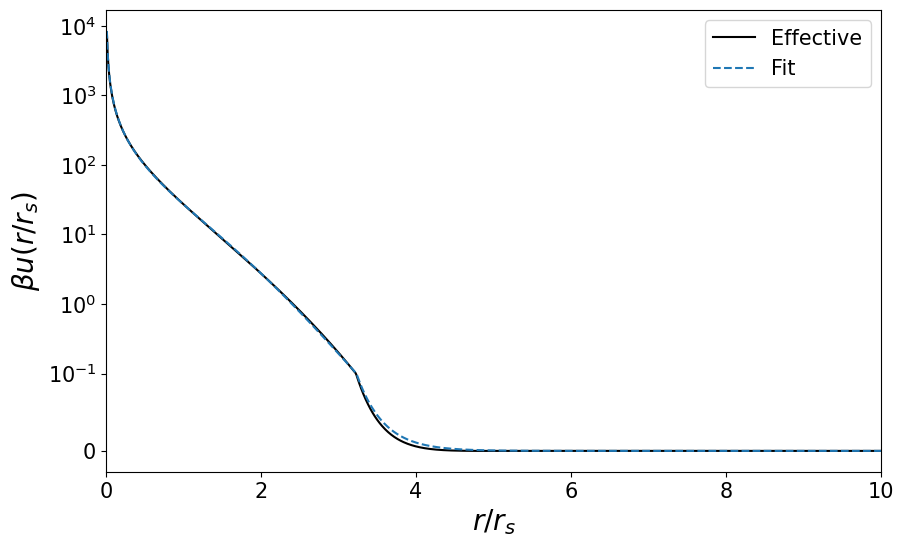

In [177]:
fig, ax = plt.subplots(figsize=(10,6))

g_data = hnc2.h_r_matrix[0,0] + 1

# LJ_fit_data  = LJ_fit(hnc2.r_array, LJ_vals[0][0],LJ_vals[0][1],LJ_vals[0][2],LJ_vals[0][3])
# yf_fit_data = yukawa_friedel_fit(hnc2.r_array, yf_vals[0][0],yf_vals[0][1],yf_vals[0][2],yf_vals[0][3],yf_vals[0][4],yf_vals[0][5],yf_vals[0][6])
yp_fit_data = yukawa_plus_fit(hnc2.r_array, yp_vals[0][0],yp_vals[0][1],yp_vals[0][2],yp_vals[0][3],yp_vals[0][4])


ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0],'k-', label="Effective")
# ax.plot(hnc2.r_array, y_fit_data*y_remaining_fit_data,'--', label="Yukawa Fit")
ax.plot(hnc2.r_array, 81.87504124/hnc2.r_array*np.exp(-0.99115223*hnc2.r_array)/(0.92620556+0.7351028*np.exp(1.72217623*(hnc2.r_array-1.75197859))),'--', label="Fit")
# ax.plot(hnc2.r_array[1:], hnc2.βueff_r_matrix[0,0][1:]-hnc2.βueff_r_matrix[0,0][:-1],'k-', label="Effective")
# ax.plot(hnc2.r_array[1:], (y_fit_data*y_remaining_fit_data)[1:]-(y_fit_data*y_remaining_fit_data)[:-1],'--', label="Yukawa Fit")

# ax.plot(hnc2.r_array, LJ_fit_data,'--', label="Yukawa Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]-y_fit_data*y_remaining_fit_data,'.', label="Yukawa Fit Ratio")
 
# ax.plot(hnc2.r_array,y_remaining_fit_data,'.', label="Yukawa Remaining Fit")

# ax.plot(hnc2.r_array, yf_fit_data,'.', label="Yukawa-Friedel Fit")
# ax.plot(hnc2.r_array, yp_fit_data,'.', label="Yukawa-Plus Fit")
# ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/yp_fit_data,'.', label="Yukawa-Plus Fit Ratio")
# ax.plot(hnc2.r_array, 1/(1+np.exp(3*(hnc2.r_array-2.5))),'.', label="Yukawa-Friedel Fit")

ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
# ax.set_ylim(-2,2)
ax.set_yscale('symlog',linthresh=1e-1)
ax.set_xlim(0,10)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

In [143]:
from scipy.interpolate import RBFInterpolator



RBFInterpolator(hnc2.r_array, hnc2.βueff_r_matrix[0,0]/y_fit_data)

ValueError: `y` must be a 2-dimensional array.